In this notebook I compare different type of GNN operaters implented in PyG. Namely the SAGEConv and GATConv. This is a preselection to find out wheter one or the other operator performs better on the MovieLens data.

In [1]:
import json
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, LGConv, GraphConv, LEConv, WLConvContinuous, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Get (preprocessed) data

In [3]:
user_path = './datasets/20221108_movieLens100k_users.csv'
movie_path = './datasets/20221108_movieLens100k_movies.csv'
rating_path = './datasets/20221108_movieLens100k_ratings.csv'

user_df, movie_df, rating_df = pd.read_csv(user_path), pd.read_csv(movie_path), pd.read_csv(rating_path)

user_df.shape, movie_df.shape, rating_df.shape

((671, 1), (9125, 24), (100004, 3))

In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [5]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   Action       9125 non-null   int64  
 2   Adventure    9125 non-null   int64  
 3   Animation    9125 non-null   int64  
 4   Children     9125 non-null   int64  
 5   Comedy       9125 non-null   int64  
 6   Crime        9125 non-null   int64  
 7   Documentary  9125 non-null   int64  
 8   Drama        9125 non-null   int64  
 9   Fantasy      9125 non-null   int64  
 10  Film-Noir    9125 non-null   int64  
 11  Horror       9125 non-null   int64  
 12  IMAX         9125 non-null   int64  
 13  Musical      9125 non-null   int64  
 14  Mystery      9125 non-null   int64  
 15  Romance      9125 non-null   int64  
 16  Sci-Fi       9125 non-null   int64  
 17  Thriller     9125 non-null   int64  
 18  War          9125 non-null   int64  
 19  Wester

In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


### Get user embeddings

In [7]:
user_embeddings = np.load('./datasets/20221125_np_user_embeddings.npy')
user_embeddings.shape

(671, 8)

In [8]:
assert not user_df.isnull().values.any(), 'Null values in user dataset!'
assert not movie_df.isnull().values.any(), 'Null values in movie dataset!'
assert not rating_df.isnull().values.any(), 'Null values in rating dataset!'

### Create Pytorch Geometric (heterogenious) Dataset

In [9]:
x_user = torch.Tensor(user_embeddings)
x_user.size()

torch.Size([671, 8])

In [10]:
x_movie = movie_df.drop(columns=['movieId'], axis=1)
x_movie = torch.Tensor(x_movie.values)
x_movie.size()

torch.Size([9125, 23])

In [11]:
edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index.size(), edge_index

(torch.Size([2, 100004]),
 tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1087, 1083, 1140,  ..., 3213, 3220, 3223]]))

In [12]:
edge_label = torch.Tensor(rating_df['rating'].values)
edge_label.size(), edge_label

(torch.Size([100004]),
 tensor([2.0000, 3.5000, 1.0000,  ..., 4.0000, 3.5000, 3.5000]))

In [13]:
data = HeteroData()
data['user'].x = x_user
data['movie'].x = x_movie

data[('user', 'rates', 'movie')].edge_index = edge_index
data[('user', 'rates', 'movie')].edge_label = edge_label

data

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  }
)

In [14]:
data = ToUndirected()(data)
del data[('movie', 'rev_rates', 'user')].edge_label

data = data.to(device)
data

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)

### Train / Test Split

In [15]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [16]:
# save
torch.save(train_data, './datasets/pyg_movielens_userEmbed_train.pt')
torch.save(val_data, './datasets/pyg_movielens_userEmbed_val.pt')
torch.save(test_data, './datasets/pyg_movielens_userEmbed_test.pt')

In [17]:
print('Train:', train_data)

Train: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 80004],
    edge_label=[80004],
    edge_label_index=[2, 80004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80004] }
)


### GNN Model

In [18]:

class SAGEConvEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class GATConvEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, n_heads):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=n_heads, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, heads=n_heads, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, multiplier):
        super().__init__()
        self.lin1 = Linear(multiplier * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class SAGEConvEncoderOnlyModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class SAGEModel(torch.nn.Module):
    def __init__(self, hidden_channels, multiplier):
        super().__init__()
        self.encoder = SAGEConvEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, multiplier)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


class GATModel(torch.nn.Module):
    def __init__(self, hidden_channels, n_heads, multiplier):
        super().__init__()
        self.encoder = GATConvEncoder(hidden_channels, hidden_channels, n_heads)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, multiplier)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [19]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
def lazy_init(model):
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters())
    return optimizer
    

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    target = data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [20]:
DO_CV_COMPARISON = True

In [21]:
if not DO_CV_COMPARISON:
    print('Cross validation is not computed!')
else:
    print('Cross validation computing...')

    EPOCHS = 300
    CV = 5
    model_names = ['SAGE', 'GAT_1', 'GAT_2', 'GAT_4']
    results = {}

    for model_name in model_names:
        print(model_name)

        results[model_name] = {}
        results[model_name]['train_losses'] = []
        results[model_name]['val_losses'] = []
        results[model_name]['test_losses'] = []
        results[model_name]['time_elapsed'] = []

        for run in range(CV):
            if model_name == 'SAGE':
                model = SAGEModel(hidden_channels=64, multiplier=2).to(device)
            elif model_name == 'GAT_1':
                model = GATModel(hidden_channels=64, n_heads=1, multiplier=2).to(device)
            elif model_name == 'GAT_2':
                model = GATModel(hidden_channels=64, n_heads=2, multiplier=2*2).to(device)
            elif model_name == 'GAT_4':
                model = GATModel(hidden_channels=64, n_heads=4, multiplier=2*4).to(device)
            else:
                raise NameError
            
            optimizer = lazy_init(model)
            train_start_time = datetime.now()
            train_losses, val_losses, test_losses = [], [], []

            for eporch in range(EPOCHS):
                train_loss = train(model=model, optimizer=optimizer, data=train_data)
                val_loss = test(model=model, data=val_data)
                test_loss = test(model=model, data=test_data)

                train_losses.append(train_loss), val_losses.append(val_loss), test_losses.append(test_loss)

            train_time_elapsed = datetime.now() - train_start_time
            print(f'\tTraining run #{run+1} took: {train_time_elapsed}\tloss: {val_loss:.3f}')

            results[model_name]['train_losses'].append(train_losses)
            results[model_name]['val_losses'].append(val_losses)
            results[model_name]['test_losses'].append(test_losses)
            results[model_name]['time_elapsed'].append(train_time_elapsed.total_seconds())

Cross validation computing...
SAGE
	Training run #1 took: 0:01:54.069920	loss: 0.876
	Training run #2 took: 0:01:54.372537	loss: 0.889
	Training run #3 took: 0:01:59.939386	loss: 0.887
	Training run #4 took: 0:02:03.601064	loss: 0.885
	Training run #5 took: 0:02:01.439848	loss: 0.877
GAT_1
	Training run #1 took: 0:03:33.139227	loss: 0.944
	Training run #2 took: 0:03:39.303727	loss: 0.981
	Training run #3 took: 0:03:39.956766	loss: 0.949
	Training run #4 took: 0:03:39.292303	loss: 0.931
	Training run #5 took: 0:03:31.171152	loss: 0.923
GAT_2
	Training run #1 took: 0:05:19.751669	loss: 0.966
	Training run #2 took: 0:05:18.928981	loss: 0.928
	Training run #3 took: 0:05:44.808766	loss: 0.945
	Training run #4 took: 0:05:45.408833	loss: 0.977
	Training run #5 took: 0:05:49.512254	loss: 0.930
GAT_4
	Training run #1 took: 0:10:19.488393	loss: 0.976
	Training run #2 took: 0:10:41.734648	loss: 0.947
	Training run #3 took: 0:10:47.939149	loss: 0.960
	Training run #4 took: 0:10:17.339101	loss: 0.9

In [22]:
if DO_CV_COMPARISON:
    results_json = json.dumps(results, indent=4)
    with open('./gnn_model_comparison_results.json', 'w') as f:
        f.write(results_json)
else:
    with open('./gnn_model_comparison_results.json', 'r') as f:
        results = json.load(f)

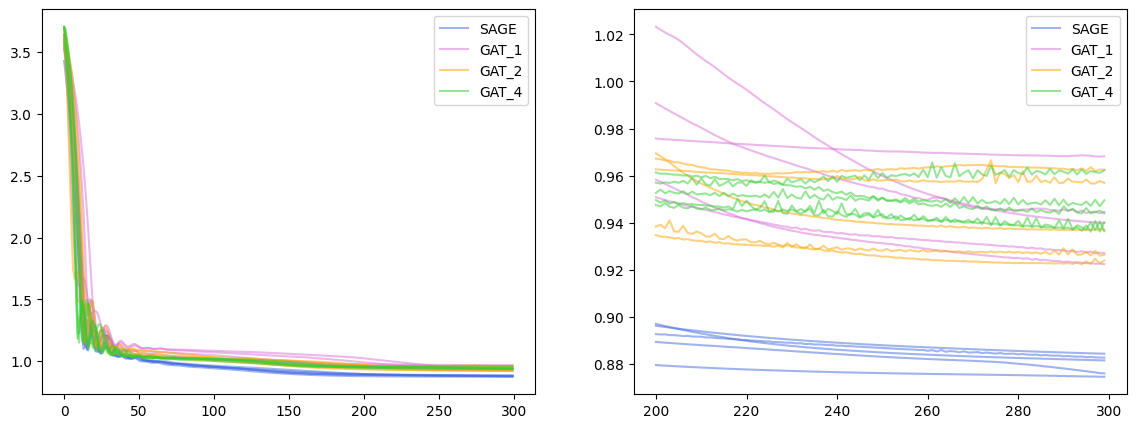

In [23]:
OFFSET = 200
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
color_list = ['royalblue', 'orchid', 'orange', 'limegreen'] #'yellow', 'cyan'
assert len(results) == len(color_list)

for model, color in zip(results.keys(), color_list):
    train_losses = results[model]['train_losses']
    test_losses = results[model]['test_losses']
    for i, test_loss in enumerate(test_losses):
        if i == 0:
            ax0.plot(test_loss, label=model, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], label=model, c=color, alpha=0.5)
        else:
            ax0.plot(test_loss, c=color, alpha=0.5)
            ax1.plot(range(OFFSET, len(test_loss)), test_loss[OFFSET:], c=color, alpha=0.5)

ax0.legend()
ax1.legend()
plt.show()

In [24]:
POOL_SIZE = 3
model_losses, model_training_times, model_names = [], [], []
for model, color in zip(results.keys(), color_list):
    test_losses = results[model]['test_losses']
    train_durations = results[model]['time_elapsed']
    
    avg_final_test_losses, avg_train_durations = [], []
    for test_loss in test_losses:
        avg_final_test_losses.append(sum(test_loss[-POOL_SIZE:]) / POOL_SIZE)
        avg_train_durations.append(sum(train_durations) / len(train_durations))
    
    model_names.append(model)
    model_losses.append(avg_final_test_losses)
    model_training_times.append(avg_train_durations)

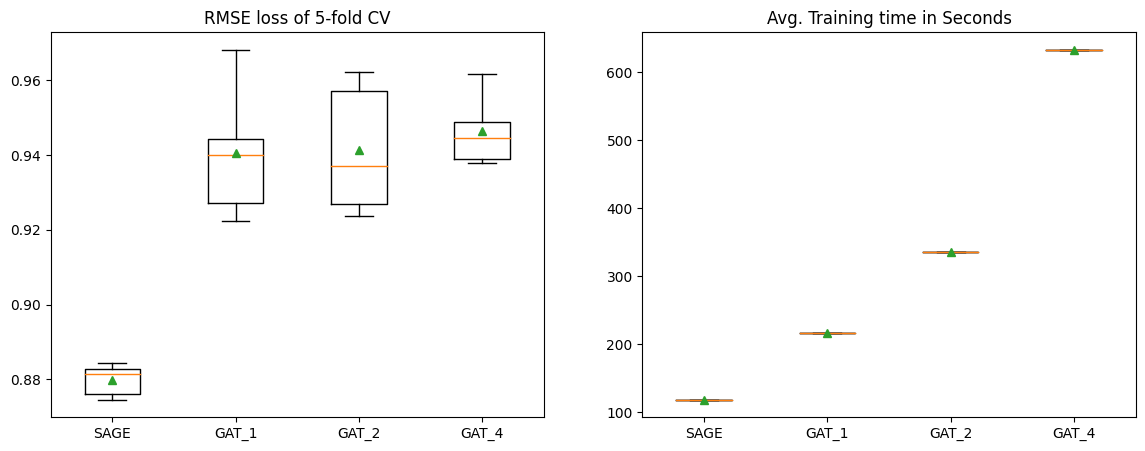

In [25]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

ax0.boxplot(model_losses, labels=model_names, showmeans=True)
ax0.set_title('RMSE loss of 5-fold CV')
ax1.boxplot(model_training_times, labels=model_names, showmeans=True)
ax1.set_title('Avg. Training time in Seconds')
plt.show()